---

# Lib

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MultiLabelBinarizer

from utils.other import parse_label

---

# Read file

In [32]:
df = pd.read_csv("../data/raw/train.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [33]:
df.head()

,brand,model,version,year,segment,comment,label
0,hyundai,creta,n line,2025,suv,"Mẫu này đẹp và hiện đại hơn, mặt đồng hồ trung...",{EXTERIOR#Positive};{INTERIOR#Negative};
1,hyundai,creta,n line,2025,suv,Creta vẫn nên phải ở tầm giá Xforce hoặc thấp ...,{COST#Neutral};{EXTERIOR#Neutral};
2,hyundai,creta,n line,2025,suv,"Giá như cx5 dl, mặc dù con này rộng hơn và k s...",{COST#Positive};
3,hyundai,creta,n line,2025,suv,Giá cao quá đợi chương trình khuyến mại thôi,{COST#Negative};
4,hyundai,creta,n line,2025,suv,Creta là một trong những con xe mượt mà nhất c...,{EXTERIOR#Positive};{INTERIOR#Positive};{PERFO...


---

# EDA

In [34]:
print(f"{df.shape[0]} rows")
print(f"{df.shape[1]} columns")

908 rows
7 columns


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    908 non-null    object
 1   model    908 non-null    object
 2   version  537 non-null    object
 3   year     908 non-null    int64 
 4   segment  908 non-null    object
 5   comment  908 non-null    object
 6   label    908 non-null    object
dtypes: int64(1), object(6)
memory usage: 49.8+ KB


## Missing values

Sự null này là MNAR (Missing not a random) tức version được thiếu vì:
- video, người đánh giá không đề cập rõ về version cụ thể của xe mà đánh giá chung về model xe đó hoặc các loại xe.
- Không quá khác biệt về thiết kế nột thất hoặc ngoại thất mà có thể là sự khác biệt về động cơ hoặc các tính năng, công nghệ được trang bị.
- Xe chỉ có duy nhất 1 version được bán ra thị trường với tên brand + model

In [36]:
df.isnull().sum()

brand        0
model        0
version    371
year         0
segment      0
comment      0
label        0
dtype: int64

## Categorical columns

In [37]:
for col in df.columns[:-2]:
    num_unique_values = df[col].nunique()
    print(f"{col}: {num_unique_values} unique values")

brand: 7 unique values
model: 10 unique values
version: 7 unique values
year: 2 unique values
segment: 2 unique values


In [38]:
for col in df.columns[:-2]:
    print(f"{col}: {df[col].unique()}")
    print()

brand: ['hyundai' 'toyota' 'mitsubishi' 'kia' 'honda' 'omoda' 'byd']

model: ['creta' 'yaris cross' 'xforce' 'seltos' 'hr-v' 'c5' 'seal 5' 'atto 3'
 'atto 2' 'sealion 6']

version: ['n line' 'máy xăng' 'ultimate' 'facelift' 'g' 'l' nan 'dm-i']

year: [2025 2024]

segment: ['suv' 'sedan']



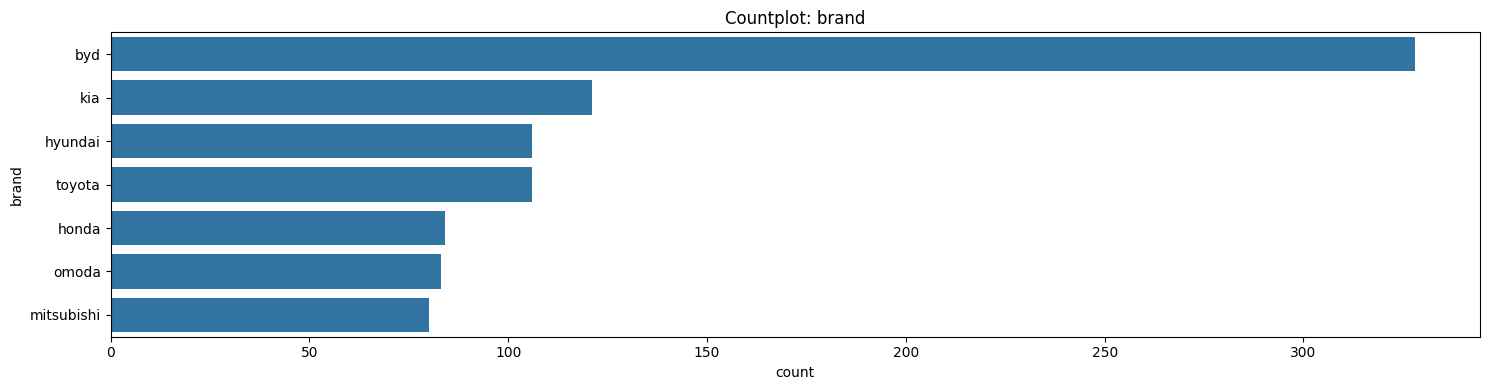

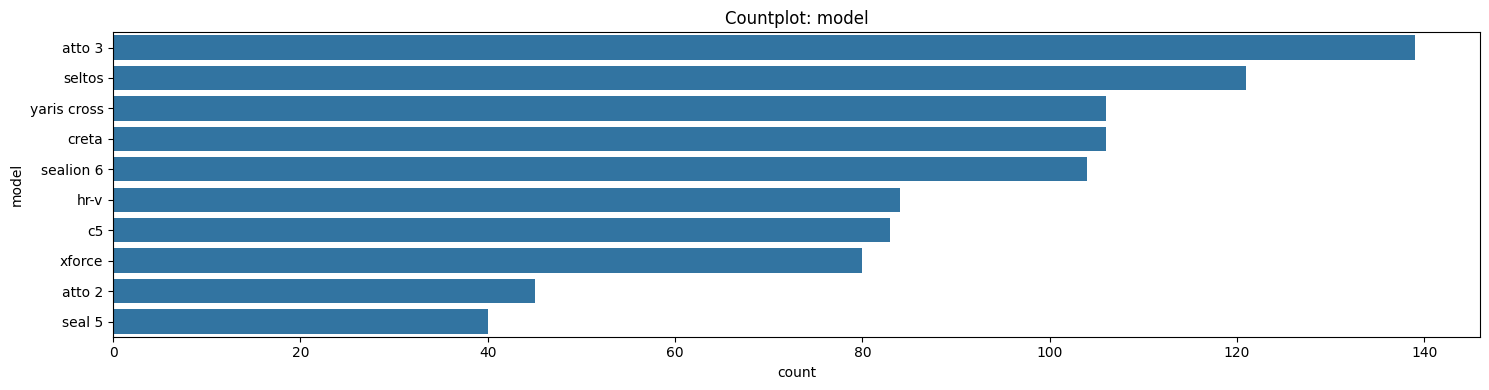

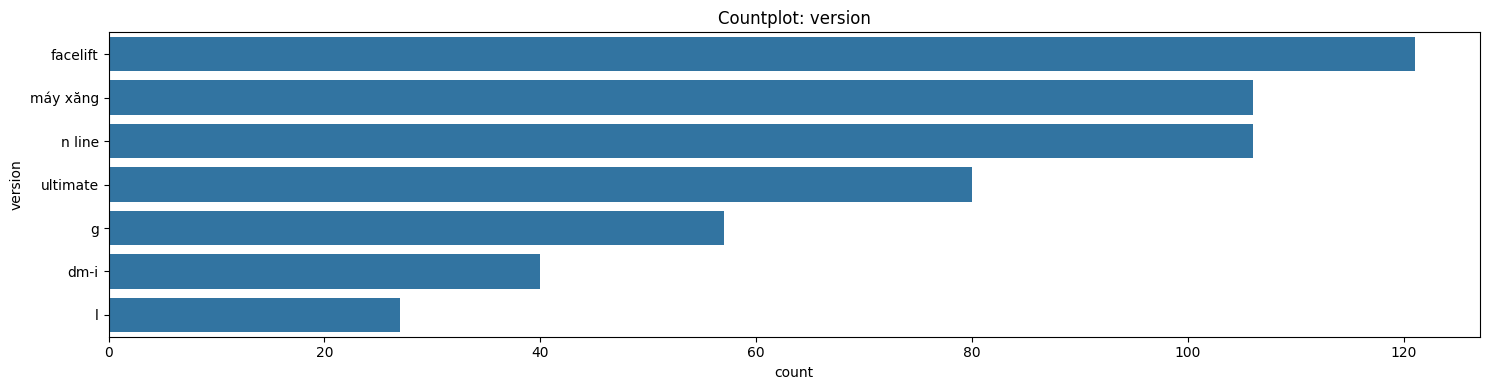

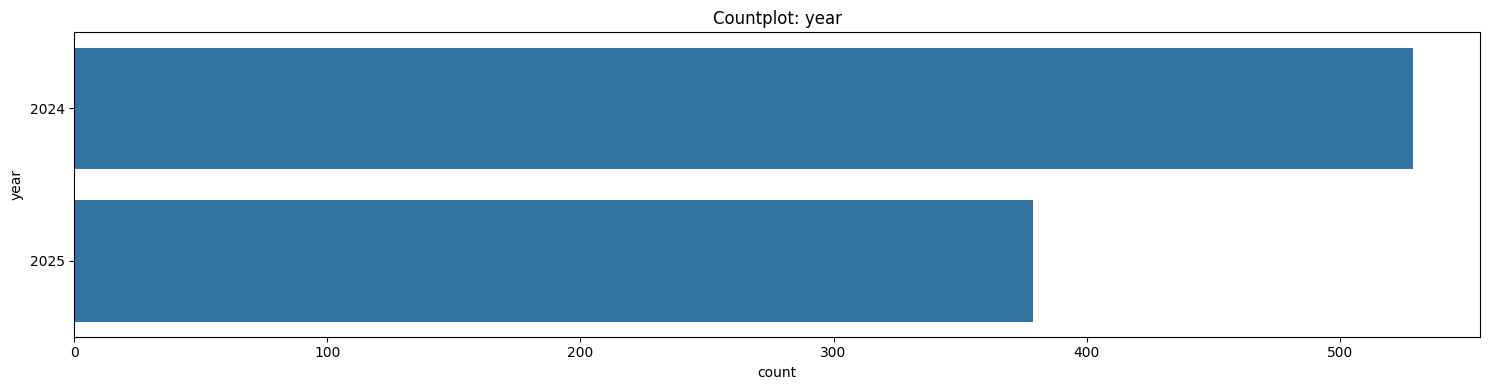

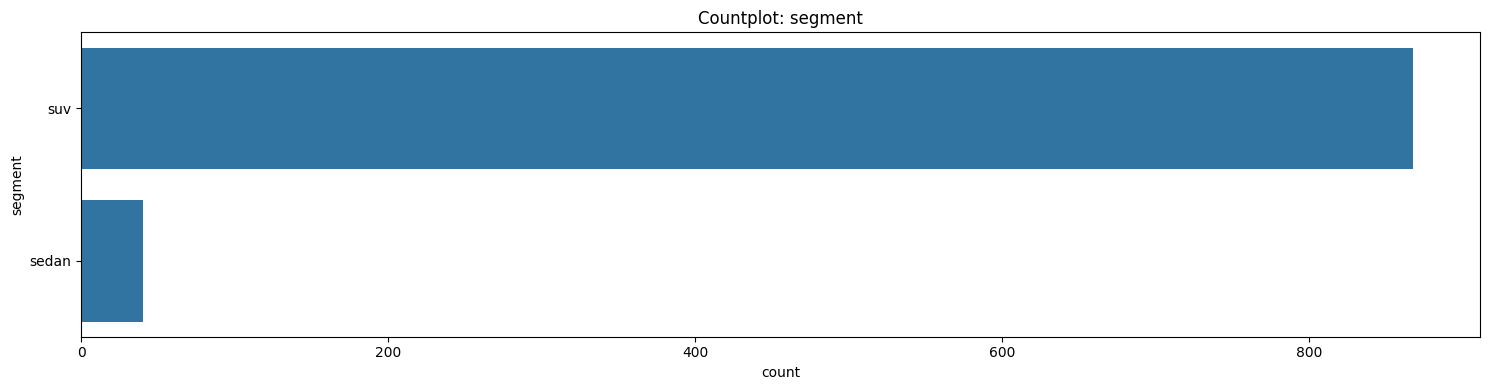

In [39]:
for col in df.columns[:-2]:
    counts = df[col].value_counts()
    plt.figure(figsize=(15, 4))
    sns.countplot(y=col, data=df, order=counts.index)
    plt.title(f"Countplot: {col}")
    plt.tight_layout()
    plt.show()

---

# Labels

In [40]:
df_label = df[["comment", "label"]].copy()

In [41]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  908 non-null    object
 1   label    908 non-null    object
dtypes: object(2)
memory usage: 14.3+ KB


In [42]:
df_label.head()

,comment,label
0,"Mẫu này đẹp và hiện đại hơn, mặt đồng hồ trung...",{EXTERIOR#Positive};{INTERIOR#Negative};
1,Creta vẫn nên phải ở tầm giá Xforce hoặc thấp ...,{COST#Neutral};{EXTERIOR#Neutral};
2,"Giá như cx5 dl, mặc dù con này rộng hơn và k s...",{COST#Positive};
3,Giá cao quá đợi chương trình khuyến mại thôi,{COST#Negative};
4,Creta là một trong những con xe mượt mà nhất c...,{EXTERIOR#Positive};{INTERIOR#Positive};{PERFO...


## Parsed label

In [43]:
df_label["parsed_labels"] = df_label["label"].apply(parse_label)

In [44]:
print(df_label['parsed_labels'].head())
print()
print(df_label['parsed_labels'].iloc[0])

0               [EXTERIOR#Positive, INTERIOR#Negative]
1                     [COST#Neutral, EXTERIOR#Neutral]
2                                      [COST#Positive]
3                                      [COST#Negative]
4    [EXTERIOR#Positive, INTERIOR#Positive, PERFORM...
Name: parsed_labels, dtype: object

['EXTERIOR#Positive', 'INTERIOR#Negative']


## Create binary matrix for multi-label classification

In [45]:
# Use MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [46]:
# Binary matrix for multi-label classification
matrix_label = mlb.fit_transform(df_label['parsed_labels'])

In [47]:
y = pd.DataFrame(matrix_label, columns=mlb.classes_)
y.head()

,BRAND#Negative,BRAND#Neutral,BRAND#Positive,COST#Negative,COST#Neutral,COST#Positive,EXTERIOR#Negative,EXTERIOR#Neutral,EXTERIOR#Positive,FEATURES#Negative,FEATURES#Neutral,FEATURES#Positive,INTERIOR#Negative,INTERIOR#Neutral,INTERIOR#Positive,PERFORMANCE#Negative,PERFORMANCE#Neutral,PERFORMANCE#Positive
0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1


In [48]:
label_counts = y.sum(axis=0).sort_values(ascending=False)
total_labels = int(y.values.sum())

In [49]:
print(f"Total labels: {total_labels}")

Total labels: 1393


In [50]:
print(f"Unique labels: {mlb.classes_}")

Unique labels: ['BRAND#Negative' 'BRAND#Neutral' 'BRAND#Positive' 'COST#Negative'
 'COST#Neutral' 'COST#Positive' 'EXTERIOR#Negative' 'EXTERIOR#Neutral'
 'EXTERIOR#Positive' 'FEATURES#Negative' 'FEATURES#Neutral'
 'FEATURES#Positive' 'INTERIOR#Negative' 'INTERIOR#Neutral'
 'INTERIOR#Positive' 'PERFORMANCE#Negative' 'PERFORMANCE#Neutral'
 'PERFORMANCE#Positive']


In [51]:
label_counts

EXTERIOR#Positive       179
COST#Negative           177
COST#Positive           132
PERFORMANCE#Positive    127
BRAND#Negative          121
PERFORMANCE#Negative    113
EXTERIOR#Negative       100
INTERIOR#Positive        88
FEATURES#Positive        86
FEATURES#Negative        77
BRAND#Positive           74
INTERIOR#Negative        71
COST#Neutral             18
PERFORMANCE#Neutral      10
EXTERIOR#Neutral          7
BRAND#Neutral             6
FEATURES#Neutral          5
INTERIOR#Neutral          2
dtype: int64

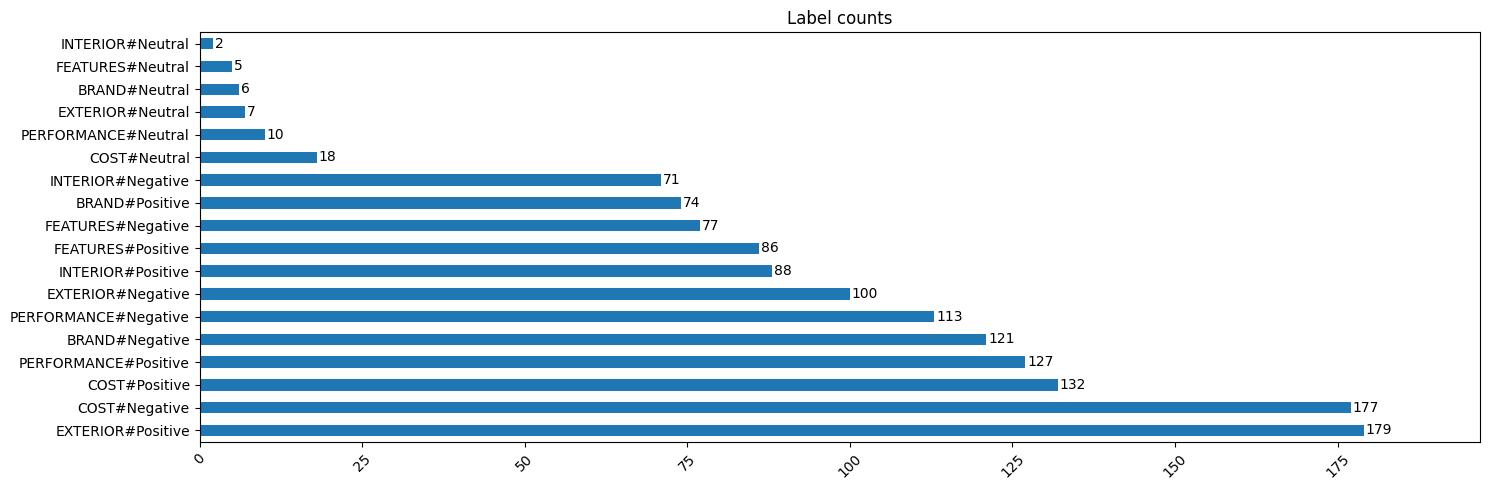

In [52]:
ax = label_counts.plot(kind='barh', figsize=(15,5), title='Label counts')
plt.xticks(rotation=45)
plt.tight_layout()
max_width = int(label_counts.max())
for p in ax.patches:
    value = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    x = p.get_x() + p.get_width() + 0.3
    ax.text(x, y, str(value), va='center', ha='left', fontsize=10)
ax.set_xlim(0, max_width * 1.10) 
plt.show()